<a href="https://colab.research.google.com/github/boneeyah/QTW/blob/main/Case%20Study%203/Case_Study_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
%%capture
!pip install beautifulsoup4
!pip install scikit-learn-intelex

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
!ls -l /content/drive/MyDrive/SpamAssassinMessages/

total 20
drwx------ 2 root root 4096 Jun 11 23:08 easy_ham
drwx------ 2 root root 4096 Jun 11 23:08 easy_ham_2
drwx------ 2 root root 4096 Jun 11 23:08 hard_ham
drwx------ 2 root root 4096 Jun 11 23:08 spam
drwx------ 2 root root 4096 Jun 11 23:08 spam_2


In [12]:
from gensim.parsing.preprocessing import STOPWORDS
from nltk import word_tokenize
import os, chardet, email
import pandas as pd 
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report
from nltk.corpus import stopwords
import nltk; nltk.download('popular')
import seaborn as sns

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [2]:
file_list = []
for root, dirs, files in os.walk("/content/drive/MyDrive/SpamAssassinMessages/", topdown=False):
    for name in files:
        tmp = os.path.join(root,name)
        file_list.append(tmp)
    for item in dirs:
        print(item)
i=0

file_list_full = []
while i < len(file_list):
    file_list_full.append(file_list[i])
    i+=1

easy_ham
easy_ham_2
hard_ham
spam_2
spam


In [3]:
len(file_list_full)

9353

In [4]:
%%capture
contents = []
types = []
labels = []
sender = []

i = 0

for root, dirs, files in os.walk("/content/drive/MyDrive/SpamAssassinMessages/"):
    for name in files:
        blob = open(os.path.join(root, name), 'rb').read()

        # Determining the encoding of the email
        result = chardet.detect(blob)
        encoding_dynamic = result['encoding']

        with open(os.path.join(root, name), 'rb') as f:
            decoded_email = f.read().decode(encoding_dynamic, errors='replace')
            
            x = email.message_from_string(decoded_email)
            print('normal', os.path.join(root, name))
            i += 1

            #adding in the sender's domain as a new column
            sender_raw = x.get('From')
            if sender_raw:
                sender_domain = sender_raw.split('@')[-1]
                if sender_domain:
                    sender.append(sender_domain)
                else:
                    sender.append("missing")
            else:
                sender.append("missing")


            if "multipart" in x.get_content_type():
                content_parts = []
                for part in x.walk():
                    if part.get_content_type() == "text/plain":
                        decoded_part = part.get_payload(decode=True).decode(encoding_dynamic, errors='replace')
                        content_parts.append(decoded_part.replace("\n", " "))
                    elif part.get_content_type() == "text/html":
                        soup = BeautifulSoup(part.get_payload(decode=True).decode(encoding_dynamic, errors='replace'), 'html.parser')
                        decoded_part = soup.get_text().replace("\n", " ")
                        content_parts.append(decoded_part)
                content = "\n".join(content_parts)
                contents.append(content)
                types.append(x.get_content_type())

            elif "text/plain" in x.get_content_type():
                decoded_content = x.get_payload(decode=True).decode(encoding_dynamic, errors='replace')
                contents.append(decoded_content.replace("\n", " "))
                types.append(x.get_content_type())

            elif "text/html" in x.get_content_type():
                soup = BeautifulSoup(x.get_payload(decode=True).decode(encoding_dynamic, errors='replace'), 'html.parser')
                decoded_content = soup.get_text().replace("\n", " ")
                contents.append(decoded_content)
                types.append(x.get_content_type())

            if "ham" in root:
                labels.append(0)
            elif "spam" in root:
                labels.append(1)
            else:
                print("YOU HAVE A BIG PROBLEM -- LABEL NOT FOUND")


In [5]:
print('contents length: ', len(contents))
print('types length: ', len(types))
print('labels length: ', len(labels))
print('file list length: ', len(file_list_full))
print('sender length: ', len(sender))

contents length:  9353
types length:  9353
labels length:  9353
file list length:  9353
sender length:  9353


In [6]:
# Encode the contents array to utf-8, before it gets added to pandas dataframe
encoded_contents = [content.encode('utf-8', errors='replace') for content in contents]

In [7]:
data = pd.DataFrame({"Text":encoded_contents,"Label":labels, "Type":types, "Filename": file_list_full, "Sender": sender})
data

,Text,Label,Type,Filename,Sender
0,"b' ""Kerry Nice"" said: > What about some reali...",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ea...,example.com (Justin Mason)
1,"b"" This may be a little off topic but thought ...",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ea...,b2unow.com>
2,"b' ""Clark C . Evans"" said: > Hello. I\'m hos...",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ea...,example.com (Justin Mason)
3,"b'This is not directly SpamAssassin related, b...",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ea...,attbi.com>
4,"b'On Wed, Sep 11, 2002 at 01:46:19PM -0700, Da...",0,text/plain,/content/drive/MyDrive/SpamAssassinMessages/ea...,ansf.alcatel.fr>
...,...,...,...,...,...
9348,"b"" Tell Me Where to Send Your Health Card ...",1,text/html,/content/drive/MyDrive/SpamAssassinMessages/sp...,sendgreatoffers.com>
9349,"b"" What does it mean to be made in the USA? C...",1,multipart/alternative,/content/drive/MyDrive/SpamAssassinMessages/sp...,insiq.us>
9350,b'_/ _/ _/ _/ _/ _/ _/ _/ _/ _/ _/ _/ _/ _/ _/...,1,text/plain,/content/drive/MyDrive/SpamAssassinMessages/sp...,msn.com>
9351,b'mv 00001.7848dde101aa985090474a91ec93fcf0 00...,1,text/plain,/content/drive/MyDrive/SpamAssassinMessages/sp...,missing


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      9353 non-null   object
 1   Label     9353 non-null   int64 
 2   Type      9353 non-null   object
 3   Filename  9353 non-null   object
 4   Sender    9353 non-null   object
dtypes: int64(1), object(4)
memory usage: 365.5+ KB


In [9]:
data['Text'] = data['Text'].astype('|S') # which will by default set the length to the max len it encounters
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Text      9353 non-null   |S202500
 1   Label     9353 non-null   int64   
 2   Type      9353 non-null   object  
 3   Filename  9353 non-null   object  
 4   Sender    9353 non-null   object  
dtypes: bytes1620000(1), int64(1), object(3)
memory usage: 1.8+ GB


In [138]:
data['Label'].value_counts() #distribution of spam/ham

0    6954
1    2399
Name: Label, dtype: int64

In [167]:
stop = list(stopwords.words('english'))
#to add additional words to stop words
#stop.extend('myword1 myword2 myword3'.split())

# MultiNB
X = data['Text']
y = data['Label'].values

skf = StratifiedKFold(n_splits=10,random_state=610,shuffle=True)
skf.get_n_splits(X,y)

#need to vectorize within pipeline to prevent data leakage (otherwise tfidf would be fitted over all the data)
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=stop, ngram_range=(2,2), analyzer='word')),
    ('estimator',MultinomialNB())
])
pipe_params = {
    'estimator__alpha':[.01,.05,.1]
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='accuracy',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(2, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern='(?u)\\b\\w+\\b')),
                ('estimator', MultinomialNB(alpha=0.01))])
0.9924087024087024


In [168]:
results_df=pd.DataFrame(results.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,16.959983,3.585672,0.877265,0.091903,0.01,{'estimator__alpha': 0.01},0.994658,0.994658,0.989316,0.992513,0.986096,0.992513,0.993583,0.992513,0.991444,0.996791,0.992409,0.002847,1
1,13.670675,0.268674,0.931188,0.076720,0.05,{'estimator__alpha': 0.05},0.989316,0.993590,0.986111,0.989305,0.988235,0.991444,0.987166,0.989305,0.990374,0.994652,0.989950,0.002538,2
2,12.392400,2.046083,0.846597,0.141579,0.1,{'estimator__alpha': 0.1},0.988248,0.987179,0.985043,0.986096,0.983957,0.987166,0.983957,0.989305,0.986096,0.992513,0.986956,0.002476,3


In [169]:
stop = list(stopwords.words('english'))
#to add additional words to stop words
#stop.extend('myword1 myword2 myword3'.split())

skf = StratifiedKFold(n_splits=10,random_state=610,shuffle=True)
skf.get_n_splits(X,y)

#need to vectorize within pipeline to prevent data leakage (otherwise tfidf would be fitted over all the data)
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=stop, ngram_range=(2,2), analyzer='word')),
    ('estimator',MultinomialNB())
])
pipe_params = {
    'estimator__alpha':[.01,.05,.1]
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='recall',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(2, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 token_pattern='(?u)\\b\\w+\\b')),
                ('estimator', MultinomialNB(alpha=0.01))])
0.9791562064156206


In [176]:
#running model on messages
X = data['Text']
y = data['Label'].values

# MultiNB with best params
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=stop, ngram_range=(2,2), analyzer='word')),
    ('estimator',MultinomialNB(alpha=results.best_params_.get('estimator__alpha')))
])
acc_score = []
rec_score = []
feature_names = []

for i, (train,test) in enumerate(skf.split(X,y)):
    my_pipe.fit(X[train],y[train])
    p = my_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))

    #feature importance by word
    feature_log_probs = my_pipe.named_steps['estimator'].feature_log_prob_
    feature_names = my_pipe.named_steps['vectorizer'].get_feature_names_out()


# Convert feature log probabilities to probabilities
feature_probs = np.exp(feature_log_probs)

# Create a DataFrame to store feature importance
feature_probability = pd.DataFrame({'Feature': feature_names,
                                   'Probability': feature_probs[1]})

# Sort feature importance by importance score
feature_probability = feature_probability.sort_values(by='Probability', ascending=False)


# saving scores for comparison    
mNB_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       696
           1       0.99      0.99      0.99       240

    accuracy                           0.99       936
   macro avg       0.99      0.99      0.99       936
weighted avg       0.99      0.99      0.99       936



AttributeError: ignored

In [ ]:
coef

[Text(0.5, 1.0, 'Top Email keywords by Probability')]

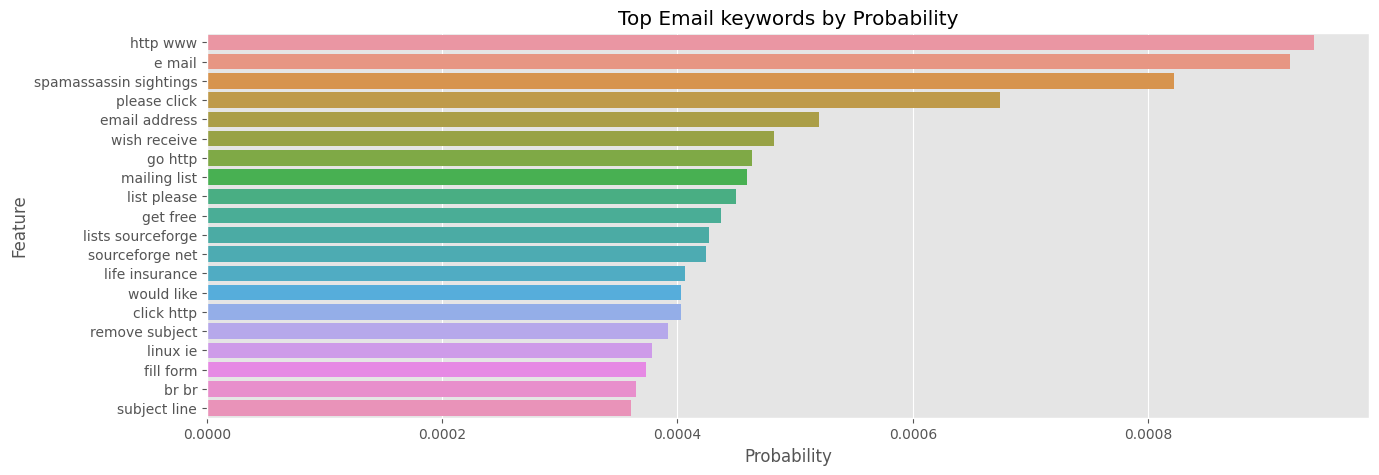

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

idx = feature_probability['Probability'].sort_values(ascending = False).head(20).index
feature_probability2 = feature_probability.loc[idx]

plt.style.use('ggplot')
plt.figure(figsize = (15,5))
sns.barplot(x='Probability',y='Feature',data=feature_probability2).set(title='Top Email keywords by Probability')

In [145]:
#rerunning model on Sender Domain
X = data['Sender']
y = data['Label'].values

# MultiNB with best params
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=stop, ngram_range=(2,2), analyzer='word')),
    ('estimator',MultinomialNB(alpha=results.best_params_.get('estimator__alpha')))
])
acc_score = []
rec_score = []
feature_names = []

for i, (train,test) in enumerate(skf.split(X,y)):
    my_pipe.fit(X[train],y[train])
    p = my_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))

    #feature importance by word
    feature_log_probs = my_pipe.named_steps['estimator'].feature_log_prob_
    feature_names = my_pipe.named_steps['vectorizer'].get_feature_names_out()


# Convert feature log probabilities to probabilities
feature_probs = np.exp(feature_log_probs)

# Create a DataFrame to store feature importance
feature_probability = pd.DataFrame({'Feature': feature_names,
                                   'Probability': feature_probs[1]})

# Sort feature importance by importance score
feature_probability = feature_probability.sort_values(by='Probability', ascending=False)


# saving scores for comparison    
mNB_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       696
           1       0.90      0.85      0.87       240

    accuracy                           0.94       936
   macro avg       0.93      0.91      0.92       936
weighted avg       0.94      0.94      0.94       936

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       696
           1       0.90      0.82      0.86       240

    accuracy                           0.93       936
   macro avg       0.92      0.89      0.91       936
weighted avg       0.93      0.93      0.93       936

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       696
           1       0.88      0.80      0.84       240

    accuracy                           0.92       936
   macro avg       0.90      0.88      0.89       936
weighted avg       0.92      0.92      0.92       936

              preci

In [165]:
feature_names.shape

(1588,)

[Text(0.5, 1.0, 'Top Sender Domains by Probability')]

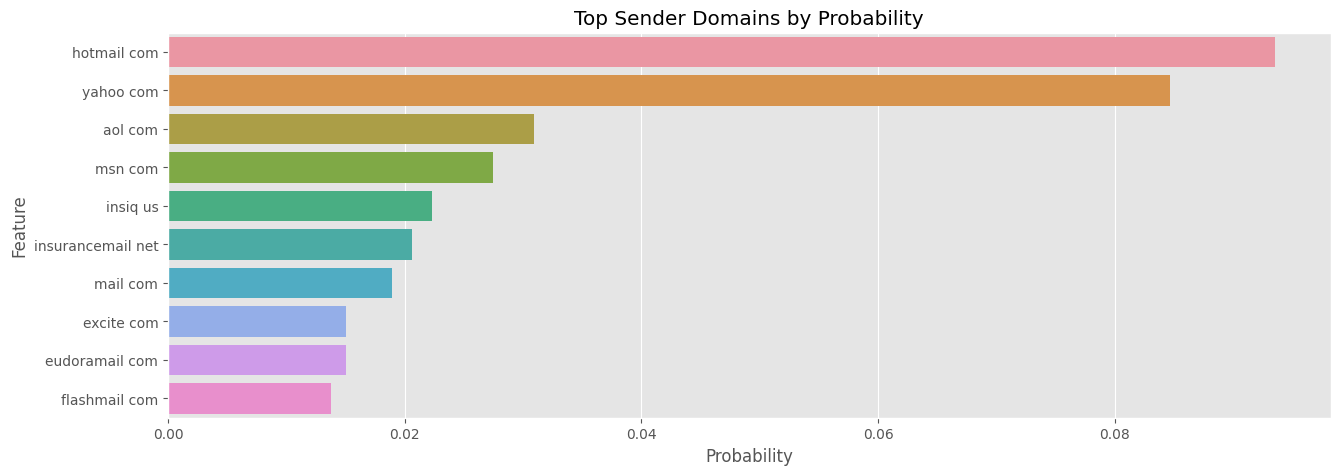

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

idx = feature_probability['Probability'].abs().sort_values(ascending = False).head(10).index
feature_probability2 = feature_probability.loc[idx]

plt.style.use('ggplot')
plt.figure(figsize = (15,5))
sns.barplot(x='Probability',y='Feature',data=feature_probability2).set(title='Top Sender Domains by Probability')

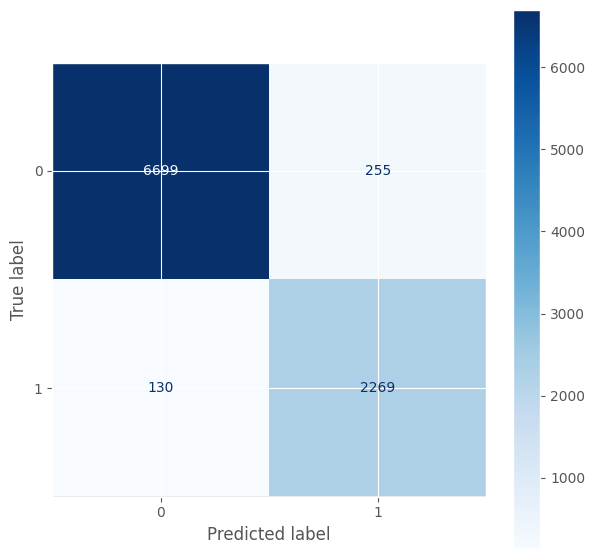

In [147]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
ConfusionMatrixDisplay.from_predictions(y,my_pipe.predict(X),cmap='Blues')

In [157]:
# support vector machine - classifier
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC

my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',SVC(random_state=610))
])
pipe_params = {
    'estimator__C':[.01,.1,.5,1],
    'estimator__gamma':['scale','auto']
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='accuracy',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(2, 2),
                                 token_pattern='(?u)\\b\\w+\\b')),
                ('estimator', SVC(C=1, random_state=610))])
0.9452564102564104


In [149]:
# svc with best params
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',SVC(random_state=610,C=results.best_params_.get('estimator__C')))#not returning best for gamma for some reason
])
acc_score = []
rec_score = []
for i, (train,test) in enumerate(skf.split(X,y)):
    my_pipe.fit(X[train],y[train])
    p = my_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))
    
svc_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       696
           1       0.87      0.97      0.92       240

    accuracy                           0.95       936
   macro avg       0.93      0.96      0.94       936
weighted avg       0.96      0.95      0.95       936

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       696
           1       0.86      0.96      0.91       240

    accuracy                           0.95       936
   macro avg       0.92      0.95      0.94       936
weighted avg       0.95      0.95      0.95       936

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       696
           1       0.86      0.95      0.90       240

    accuracy                           0.95       936
   macro avg       0.92      0.95      0.93       936
weighted avg       0.95      0.95      0.95       936

              preci

In [150]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier


my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',RandomForestClassifier(random_state=610,max_depth = 100))
])
pipe_params = {
    'estimator__n_estimators':[50,100,200],
    'estimator__class_weight':['balanced',None]
}

grid = GridSearchCV(my_pipe,pipe_params,cv=skf,scoring='accuracy',n_jobs=-1)
results = grid.fit(X,y)
print(results.best_estimator_)
print(results.best_score_)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(2, 2),
                                 token_pattern='(?u)\\b\\w+\\b')),
                ('estimator',
                 RandomForestClassifier(max_depth=100, n_estimators=200,
                                        random_state=610))])
0.8598311165958226


In [155]:
# rf best params
my_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(2,2), analyzer='word')),
    ('estimator',RandomForestClassifier(max_depth = 100,
                                        random_state=610,
                                        n_estimators = results.best_params_.get('estimator__n_estimators'),
                                        class_weight = results.best_params_.get('estimator__class_weight')))
])
acc_score = []
rec_score = []
for i, (train,test) in enumerate(skf.split(X,y)):
    my_pipe.fit(X[train],y[train])
    p = my_pipe.predict(X[test])
    acc_score.append(accuracy_score(y[test],p))
    rec_score.append(recall_score(y[test],p))
    print(classification_report(y[test],p))
    
rf_scores = pd.DataFrame({'accuracy':acc_score,
                           'recall':rec_score})

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       696
           1       0.87      0.55      0.68       240

    accuracy                           0.86       936
   macro avg       0.87      0.76      0.80       936
weighted avg       0.86      0.86      0.85       936

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       696
           1       0.88      0.50      0.64       240

    accuracy                           0.85       936
   macro avg       0.86      0.74      0.77       936
weighted avg       0.86      0.85      0.84       936

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       696
           1       0.85      0.56      0.67       240

    accuracy                           0.86       936
   macro avg       0.86      0.76      0.79       936
weighted avg       0.86      0.86      0.85       936

              preci

In [156]:
# clustering
## checking to see if KMeans can find two clusters that match fairly well with target

from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=2,n_init='auto',random_state=610).fit(X)
km_labels = clustering.labels_


ValueError: ignored

In [ ]:
# clustering
from sklearn.cluster import DBSCAN #DBSCAN works with

clustering = DBSCAN(eps=1,n_jobs=-1).fit(X)
db_labels = clustering.labels_

In [ ]:
reverse={}
for word,value in word_counts.vocabulary_.items():
    reverse[value]=word

In [18]:
mNB_scores = pd.read_csv('/content/mNB_scores.csv')
svc_scores = pd.read_csv('/content/svc_scores.csv')
rf_scores = pd.read_csv('/content/rf_scores.csv')

In [23]:
scores_df = pd.concat([mNB_scores.assign(Model = "MultiNB",Fold = mNB_scores.index),
                                 svc_scores.assign(Model = "SVC", Fold = svc_scores.index),
                                 rf_scores.assign(Model = "RandomForest", Fold = rf_scores.index)
                                 ])
scores = scores_df.melt(id_vars=["Model"],value_vars=['accuracy','recall'],var_name='Metric')
scores

,Model,Metric,value
0,MultiNB,accuracy,0.994658
1,MultiNB,accuracy,0.994658
2,MultiNB,accuracy,0.988248
3,MultiNB,accuracy,0.991444
4,MultiNB,accuracy,0.983957
5,MultiNB,accuracy,0.990374
6,MultiNB,accuracy,0.988235
7,MultiNB,accuracy,0.993583
8,MultiNB,accuracy,0.989305
9,MultiNB,accuracy,0.996791


[Text(0.5, 1.0, 'Error Distribution by Model')]

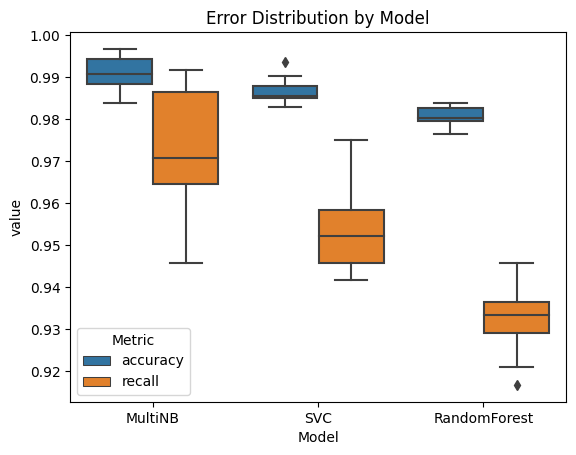

In [26]:
import seaborn as sns
sns.boxplot(scores,x='Model',y='value',hue='Metric').set(title = 'Error Distribution by Model')

In [30]:
mNB_scores[['accuracy','recall']].describe().T

,count,mean,std,min,25%,50%,75%,max
accuracy,10.0,0.991125,0.003874,0.983957,0.988512,0.990909,0.994389,0.996791
recall,10.0,0.972904,0.014733,0.945833,0.964553,0.970833,0.986458,0.991667
